# Análise de sentimentos

Vamos analisar reviews de filmes. Sem ter acesso à nota que o usuário deu ao filme, vamos analisar o comentário e verificar se foi uma experiência Positiva ou uma experiência Negativa.

## Torchtext

Biblioteca similiar ao Torchvision, o pacote facilita o trabalho com texto oferecendo ferramentas aproveitáveis para outros dados sequenciais.

Um dos principais elementos é o **Field**, objeto que carrega informações de como os dados devem ser processados.

No caso em questão, temos dois dados:

- **Texto:** Sequência de caracteres que será dividida em tokens. Armazenamos também os tamanhos das frases.

    - Ex: "A Sônia late bastante!" -> ["A", "Sônia", "late", "bastante", "!"]

            TEXTO = data.Field(tokenize = 'spacy', include_lengths = True)

- **Label:** Categorias descritas como 'pos' e 'neg'. Essas serão trasformadas para valores numéricos {negativo: 0, positivo: 1}.

            LABEL = data.LabelField(dtype = torch.long)

https://pytorch.org/text/stable/datasets.html

In [10]:
import torch
from torchtext.legacy import data, datasets
from torch import nn, optim
import torch.nn.functional as F

import numpy as np

### Preparação dos dados

In [2]:
TEXTO = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.long)

treino, teste = datasets.IMDB.splits(TEXTO, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:19<00:00, 4.27MB/s]


In [ ]:
for amostra in teste:

    print(amostra.text)
    print(amostra.label)

    break

['This', 'is', 'a', 'film', 'about', 'a', 'six', 'year', 'old', 'child', 'from', 'a', 'village', 'in', 'Maharashtra', '(', 'a', 'state', 'in', 'India', ')', 'and', 'his', 'grandfather', 'who', 'come', 'to', 'Pune', '(', 'a', 'city', 'in', 'Maharashtra', ')', 'to', 'treat', 'the', 'child', "'s", 'eyes', '.', 'here', 'the', 'grandfather', 'gets', 'to', 'know', 'that', 'the', 'child', 'has', 'cancer', 'in', 'both', 'eyes', 'and', 'that', 'they', 'have', 'to', 'be', 'removed', 'to', 'save', 'the', 'child', "'s", 'life', '.', 'the', 'movie', 'is', 'all', 'about', 'the', 'main', 'characters', "'", 'and', 'their', 'feelings', 'and', 'actions', 'until', 'the', 'operation.<br', '/><br', '/>The', 'movie', 'is', 'not', 'a', 'typical', 'cliché', 'Indian', 'movie', ',', 'so', 'dun', 'expect', 'to', 'see', 'songs', 'or', 'romance', 'or', 'melodrama', '.', 'this', 'ia', 'a', 'supremely', 'crafted', 'sensitive', 'movie', 'which', 'resorts', 'to', 'silent', 'expressions', 'rather', 'than', 'over', 'the

Para transformar palavras em dados numéricos, a solução mais simples é mapeá-las em um dicionário contendo o vocabulário completo do conjunto.

Podemos fazer isso chamando a função build_vocab nos nossos fields. Como datasets de texto podem chegar a centenas de milhares de palavras, é importante definir um limite superior para o número de palavras mapeadas pelo dicionário (MAX_VOCAB_SIZE = 25000).

In [3]:
TEXTO.build_vocab(treino, max_size=25000, vectors="glove.6B.100d")

LABEL.build_vocab(treino)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:22<00:00, 17553.43it/s]


In [ ]:
print(len(TEXTO.vocab))
print(TEXTO.vocab.freqs.most_common(10))

25002
[('the', 289838), (',', 275296), ('.', 236843), ('and', 156483), ('a', 156282), ('of', 144055), ('to', 133886), ('is', 109095), ('in', 87676), ('I', 77546)]


Utilizamos o BucketIterator para organizar os dados de forma a padronizar o tamanho das sequências, adicionando o padding nas sequências de menor tamanho. Com isso, podemos formar tensores com os dados:

In [4]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

treino_iterator, teste_iterator = data.BucketIterator.splits(
                                        (treino, teste),
                                        batch_size=64,
                                        sort_within_batch=True,
                                        device=device
                                    )

In [5]:
for amostra in teste_iterator:
    batch, tamanhos = amostra.text
    rotulo = amostra.label

    print(batch.shape)
    print(tamanhos)
    print(rotulo.shape)

    break

torch.Size([36, 64])
tensor([36, 36, 36, 36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 34, 34, 34, 34,
        33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 31, 31, 31, 31, 30, 30, 29,
        29, 29, 29, 28, 28, 28, 28, 27, 27, 27, 27, 26, 26, 23, 23, 23, 22, 22,
        22, 20, 16, 16, 13, 12, 12, 11,  8,  5])
torch.Size([64])


### Definição da RNN

In [5]:
class RNN(nn.Module):

    def __init__(self, vocab_size, embed_dim, embed_vectors, ind_unk, ind_pad, hidden_size, output_size):
        super(RNN, self).__init__()

        #### Camada de embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight.data.copy_(embed_vectors) # pesos pré treinados
        self.embedding.weight.data[ind_unk] = torch.zeros(embed_dim)
        self.embedding.weight.data[ind_pad] = torch.zeros(embed_dim)
        ####

        #### Camada recorrente
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(embed_dim, hidden_size)
        ####

        #### Camada de classificação
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, dados, tamanhos):
        embed = self.embedding(dados)

        # Inicializar memória
        hidden = torch.zeros(1, dados.size(1), self.hidden_size).to(device)
        
        # Empacote a sequência antes de alimentar a unidade recorrente
        packed_input = nn.utils.rnn.pack_padded_sequence(embed, tamanhos)
        # Forward recorrente
        packed_output, hidden = self.rnn(packed_input, hidden)
        # Desempacote a sequência para continuar o fluxo na rede
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        # Classifica a memória de maior relevância
        output = self.linear(hidden.squeeze())

        return output

In [6]:
vocab_size = len(TEXTO.vocab)
embed_size = TEXTO.vocab.vectors[0].shape[0]
embed_vectors = TEXTO.vocab.vectors
ind_unk = TEXTO.vocab.stoi[TEXTO.unk_token]
ind_pad = TEXTO.vocab.stoi[TEXTO.pad_token]
hidden_size = 256
output_size = 2

modelo = RNN(vocab_size, embed_size, embed_vectors, ind_unk, ind_pad, hidden_size, output_size).to(device)

print(modelo)

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 256)
  (linear): Linear(in_features=256, out_features=2, bias=True)
)


### Loss e Otimizador

In [7]:
criterio = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(modelo.parameters(), lr=1e-4, weight_decay=5e-5)

### Forward

In [8]:
def forward(iterator, num_samples, etapa):
    if etapa == 'Treino': modelo.train()
    else: modelo.eval()

    acuracia = 0.
    loss_epoca = []

    for k, sample in enumerate(iterator):

        texto, tamanhos = sample.text
        rotulo = sample.label

        saida = modelo(texto, tamanhos.cpu())

        loss = criterio(saida, rotulo)
        loss_epoca.append(loss.detach().cpu().numpy())

        _, pred = torch.max(saida, axis=-1)
        acuracia += (pred.cpu().data == rotulo.cpu().data).sum()

        if etapa == 'Treino':
            # otimização
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_epoca = np.asarray(loss_epoca).ravel()
    acuracia = acuracia/float(num_samples)
    print('\n','*'*15 + etapa + '*'*15)
    print('Época: {:}, Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(epoca, loss_epoca.mean(), loss_epoca.std(), acuracia))

    return loss_epoca.mean(), acuracia

In [11]:
loss_treino, loss_teste = [], []
acc_treino, acc_teste = [], []

for epoca in range(10):
    loss, acuracia = forward(treino_iterator, len(treino), 'Treino')
    loss_treino.append(loss)
    acc_treino.append(acuracia)

    loss, acuracia = forward(treino_iterator, len(teste), 'Teste')
    loss_teste.append(loss)
    acc_teste.append(acuracia)


 ***************Treino***************
Época: 0, Loss: 0.4592 +/- 0.0793, Acurácia: 0.7893

 ***************Teste***************
Época: 0, Loss: 0.4122 +/- 0.0660, Acurácia: 0.8195

 ***************Treino***************
Época: 1, Loss: 0.3872 +/- 0.0801, Acurácia: 0.8324

 ***************Teste***************
Época: 1, Loss: 0.3379 +/- 0.0709, Acurácia: 0.8586

 ***************Treino***************
Época: 2, Loss: 0.3379 +/- 0.0796, Acurácia: 0.8594

 ***************Teste***************
Época: 2, Loss: 0.3531 +/- 0.0838, Acurácia: 0.8468

 ***************Treino***************
Época: 3, Loss: 0.3053 +/- 0.0821, Acurácia: 0.8755

 ***************Teste***************
Época: 3, Loss: 0.3048 +/- 0.0548, Acurácia: 0.8810

 ***************Treino***************
Época: 4, Loss: 0.2710 +/- 0.0687, Acurácia: 0.8917

 ***************Teste***************
Época: 4, Loss: 0.2381 +/- 0.0604, Acurácia: 0.9101

 ***************Treino***************
Época: 5, Loss: 0.2416 +/- 0.0749, Acurácia: 0.9054

 **

# Utilizando o modelo

In [17]:
import spacy
nlp = spacy.load('en')

# Recebe uma frase e retorna a probabilidade de ser positivo ou negativo
def predict_sentiment(sentence):
    modelo.eval()
    tokenized = [str(tok) for tok in nlp.tokenizer(sentence)]
    print(tokenized)

    indexed = [TEXTO.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    print(indexed)
    
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    
    prediction = modelo(tensor, length_tensor)
    
    return F.softmax(prediction, dim=-1).cpu().data

['When', 'a', 'BBC', 'murder', 'thriller', 'is', 'this', 'rife', 'with', 'heterosexual', 'dysfunction', ',', 'you', 'know', 'who', 'the', 'killer', 'must', 'be', ':', 'The', 'Homosexual.<br', '/><br', '/>Who', 'murdered', 'the', 'sexy', 'blonde', 'teenager', '(', 'who', "'s", 'also', 'a', 'pathological', 'liar', ')', 'on', 'her', 'way', 'home', 'from', 'school', '?', 'Let', "'s", 'see', ',', 'could', 'it', 'be', 'the', 'mother', 'who', '(', 'against', 'all', 'common', 'sense', ')', 'is', 'letting', 'her', 'teenaged', 'son', 'make', 'unchaperoned', 'visits', 'to', 'his', 'serial', '-', 'killer', 'father', 'behind', 'bars', '?', 'Could', 'it', 'be', 'the', 'moody', 'son', ',', 'who', "'s", 'impressed', 'by', 'his', 'dad', "'s", 'no', '-', 'nonsense', 'attitude', 'about', 'women', '?', 'Could', 'it', 'be', 'the', 'serial', 'killer', 'himself', ',', 'who', 'seems', 'able', 'to', 'manipulate', 'events', 'from', 'behind', 'bars', ',', 'a', 'la', 'Hannibal', 'Lecter', '?', 'Could', 'it', 'be'

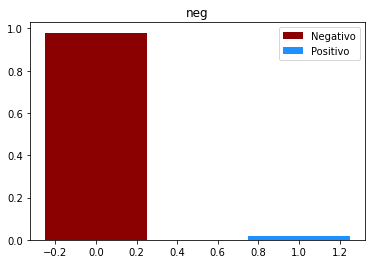

['I', 'saw', 'this', 'movie', 'with', 'my', 'girlfriend', '.', 'It', 'was', 'a', 'total', 'disaster', '.', 'You', 'can', 'really', 'see', 'it', 'was', 'cheaply', 'made', '.', 'Badly', 'scripted', 'and', 'with', 'very', 'bad', 'acting', '.', 'I', 'have', 'read', 'several', 'versions', 'of', 'the', 'book', 'by', 'different', 'authors', 'and', 'also', 'listened', 'to', 'one', 'version', 'on', 'audio', 'book', '.', 'We', 'could', "n't", 'take', 'the', 'movie', 'seriously', 'because', 'of', 'the', 'lacking', 'elements', 'it', 'should', 'have', 'contained', '.', 'The', 'experience', 'of', 'watching', 'this', 'was', 'like', 'The', 'Blair', 'Witch', 'visits', 'Green', 'Acres', '.', 'Then', 'there', 'were', 'parts', 'that', 'were', 'vulgar', '.', 'They', 'show', 'this', 'little', 'boy', 'using', 'a', 'bed', 'pan', 'and', 'they', 'actually', 'show', 'the', 'contents', 'of', 'it', '.', 'The', 'witch', 'throws', 'the', 'contents', 'of', 'it', 'on', 'the', 'boy', 'and', 'the', 'whole', 'family', 'l

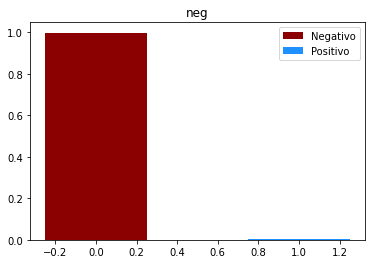

['I', 'find', 'it', 'remarkable', 'that', 'so', 'little', 'was', 'actually', 'done', 'with', 'the', 'story', 'of', 'the', 'a', '-', 'bomb', 'and', 'it', "'s", 'development', 'for', 'decades', 'after', 'the', 'Manhattan', 'Project', 'was', 'completed', '.', 'My', 'suspicion', 'is', 'that', 'this', 'was', 'due', 'to', 'serious', 'fears', 'in', 'the', 'movie', 'and', 'entertainment', 'industries', '(', 'in', 'the', '1950s', 'through', 'the', '1970s', ')', 'with', '"', 'McCarthyism', '"', 'and', 'related', 'national', 'security', 'phobias', '(', 'including', 'the', 'Hollywood', 'blacklist', ')', '.', 'There', 'was', 'one', 'film', 'in', 'the', '1950s', '(', 'with', 'Robert', 'Taylor', ')', 'about', 'Col', '.', 'Paul', 'Tibbits', 'who', 'flew', 'the', 'Enola', 'Gay', 'in', 'the', 'Hiroshima', 'bombing', ',', 'but', 'otherwise', 'nothing', 'else', '.', 'One', 'could', 'glance', 'at', 'a', 'side', 'issue', 'tragedy', '(', 'the', 'sinking', 'of', 'the', 'U.S.S.', 'Indianapolis', 'soon', 'after

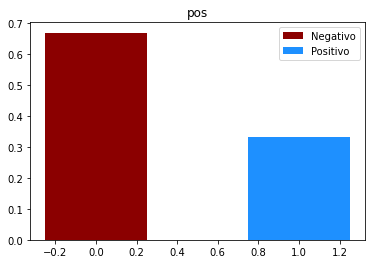

['After', 'two', 'brief', 'scenes', 'that', 'at', 'first', 'seem', 'unrelated', 'to', 'the', 'rest', 'of', 'the', 'film', ',', 'we', 'see', 'a', 'dark', '-', 'haired', ',', 'obviously', 'rich', 'beauty', 'in', 'the', 'back', 'of', 'a', 'limousine', '.', 'Her', 'driver', 'stops', 'at', 'an', 'odd', 'location', 'on', 'Mulholland', 'Drive', ',', 'which', 'is', 'a', 'twisting', ',', 'thickly', 'wooded', 'two', '-', 'lane', 'road', 'full', 'of', 'mansions', 'overlooking', 'Los', 'Angeles', '.', 'Just', 'as', 'her', 'driver', 'and', 'another', 'man', 'in', 'the', 'passenger', 'seat', 'turn', 'around', 'to', 'kill', 'her', ',', 'two', 'drag', 'racing', 'cars', 'from', 'the', 'opposite', 'direction', 'come', 'crashing', 'into', 'the', 'limo', '.', 'Only', 'the', 'dark', '-', 'haired', 'woman', 'survives', '.', 'She', 'works', 'her', 'way', 'down', 'the', 'ridge', 'to', 'Sunset', 'Boulevard', 'and', 'hides', 'in', 'a', 'vacationing', 'woman', "'s", 'apartment', '.', 'Shortly', 'after', ',', 'Be

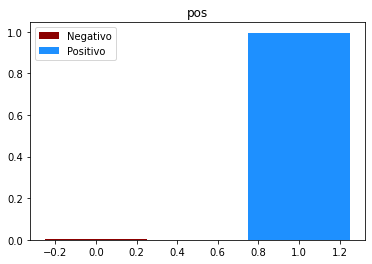

['I', 'am', 'almost', 'tempted', 'to', 'demand', 'my', 'money', 'back', 'from', 'the', 'video', 'store', '.', 'This', 'movie', 'plumbs', 'the', 'depths', 'of', 'inanity', 'and', 'is', 'almost', 'completely', 'unwatchable', '.', 'I', 'NEVER', 'bail', 'out', 'of', 'a', 'film', 'early', 'but', 'this', 'was', 'painful', 'to', 'view', '.', 'A', 'thorough', 'waste', 'of', 'celluloid', '.', 'My', 'vote', '1/10', '(', 'it', 'would', 'have', 'been', 'zero', ')', '.']
[11, 266, 249, 6327, 8, 5584, 83, 307, 168, 46, 2, 420, 1166, 4, 66, 22, 0, 2, 6931, 7, 0, 5, 9, 249, 363, 4500, 4, 11, 3952, 22677, 55, 7, 6, 24, 443, 26, 16, 19, 1408, 8, 702, 4, 149, 15484, 464, 7, 4679, 4, 390, 2503, 3726, 27, 12, 63, 34, 91, 2388, 29, 4]


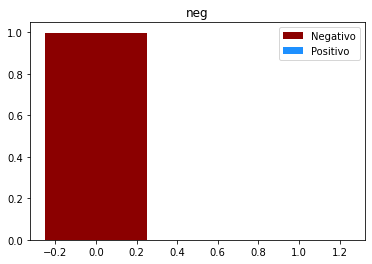

In [19]:
import matplotlib.pyplot as plt

# Escolhe 5 reviews aleatórias para analisar
np.random.seed(42)
for i in range(5):
  idx = np.random.choice(len(teste))
  text = teste[idx].text 
  pred = predict_sentiment(' '.join(text) )

  plt.bar(0, pred[0], color='darkred', label='Negativo', width=0.5)
  plt.bar(1, pred[1], color='dodgerblue', label='Positivo', width=0.5)
  plt.title(str(teste[idx].label))
  plt.legend()
  plt.show()

In [24]:
pred = predict_sentiment('I think you are a great person')
print("{:.4f}% negativo".format(pred[0]*100))
print("{:.4f}% positivo".format(pred[1]*100))

['I', 'think', 'you', 'are', 'a', 'great', 'person']
[11, 119, 31, 32, 6, 103, 426]
25.3182% negativo
74.6818% positivo


In [25]:
pred = predict_sentiment('This was horrible, the worst movie I have ever watched')
print("{:.4f}% negativo".format(pred[0]*100))
print("{:.4f}% positivo".format(pred[1]*100))

['This', 'was', 'horrible', ',', 'the', 'worst', 'movie', 'I', 'have', 'ever', 'watched']
[66, 19, 591, 3, 2, 281, 22, 11, 34, 145, 313]
96.9380% negativo
3.0620% positivo
